# 14-3-loop.ipynb

This notebook loads truth and reco level data from the prepped h5 files, preprocesses the data (i.e. scales them to be between -1 and 1, with a mean at 0), and fits the data using the pre-trained keras model.

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Input, concatenate, Masking, LSTM, TimeDistributed, Lambda, Reshape, Multiply, BatchNormalization, Bidirectional
from tensorflow.keras import regularizers 
from tensorflow.keras import initializers
import h5py
import os 
from clr_callback import *
from tensorflow.keras.callbacks import TensorBoard
import tensorflow.keras.backend as K  
from tensorflow.keras.optimizers import * 
import glob
import re
import importlib 
os.environ["CUDA_VISIBLE_DEVICES"]="1"

## Loading Files

In [6]:
# Numpy array of [max,mean] for each variable
#X_maxmean = np.load('X_maxmean_tao.npy')
#Y_maxmean = np.load('Y_maxmean_tao.npy')
X_maxmean = np.load('X_maxmean_new.npy')
Y_maxmean = np.load('Y_maxmean_new.npy')

# Prediction and truth save files
pred_name = '/data/jchishol/Jenna_Data/preds.npy'
true_name = '/data/jchishol/Jenna_Data/true.npy'

# Dataset
#name = '/data/jchishol/Tao_Data/variables_tt_rmu_padded.h5'
name = '/data/jchishol/Jenna_Data/variables_ttbar_parton_ejets.h5'
dataset = h5py.File(name,'r')

## Useful Variables

In [3]:
# Number of events in dataset
size = np.array(dataset.get('th_pt')).size
crop0 = size

# X and Y variables to be used
X_keys = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_DL1r', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_m', 'j2_DL1r', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_DL1r', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_DL1r', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_DL1r', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_DL1r', 'lep_pt', 'lep_eta', 'lep_phi', 'met_met', 'met_phi']
Y_keys = ['th_pt', 'th_eta','th_phi','th_m', 'wh_pt', 'wh_eta', 'wh_phi', 'wh_m', 'tl_pt', 'tl_eta', 'tl_phi', 'tl_m', 'wl_pt', 'wl_eta', 'wl_phi', 'wl_m']

# Variable keys, needed for helper codes
phi_keys = list(filter(lambda a: 'phi' in a, dataset.keys()))
eta_keys = list(filter(lambda a: 'eta' in a, dataset.keys()))
pt_keys =  list(filter(lambda a: 'pt' in a, dataset.keys()))
m_keys = list(filter(lambda a: 'm' in a, dataset.keys()))
DL1r_keys = list(filter(lambda a: 'DL1r' in a, dataset.keys()))

## Import Helper Codes

In [4]:
import normalize
import shape_timesteps
importlib.reload(normalize)
importlib.reload(shape_timesteps)

# Loss function needed for model fitting
def loss_fc(true, pred):
        return K.mean(K.square(true-pred)*(1+3*K.square(K.abs(true))))

## Scale the Data

In [5]:
# Scales data set to be between -1 and 1, with a mean of 0
Scaler = normalize.Scale_variables()
X_total, X_names = Scaler.scale_arrays(X_keys, X_maxmean)
Y_total, Y_names = Scaler.scale_arrays(Y_keys, Y_maxmean)

## Split and Fit Data

In [6]:
# Set how the data will be split (i.e. whether or not you want test and training data)
split = int(np.floor(0.95*crop0))    # 95% of data goes to training, 5% to testing
split = 0                            # 0 % of data goes to training, 100% to testing

# Split jet and other data
timestep_builder = shape_timesteps.Shape_timesteps()
totalX_jets, totalX_other = timestep_builder.reshape_X(X_total, X_names, False,True)

# Split into testing and training data
trainX_jets, testX_jets = totalX_jets[0:split,:,:], totalX_jets[split:,:,:]
trainX_other, testX_other = totalX_other[0:split,:], totalX_other[split:,:]
trainY, testY = Y_total[0:split,:], Y_total[split:,:]

# Test that we've split things correctly
print(testX_jets.shape, testX_other.shape, testY.shape)
if (testY.shape[0] == testX_jets.shape[0] and testY.shape[0] == testX_other.shape[0]):
    print("Agreeing shapes.")

(5627310, 6, 6) (5627310, 7) (5627310, 20)
Agreeing shapes.


In [14]:
# Define bins
other_bins = np.linspace(-1, 1, 40)
phi_bins = np.linspace(-1, 1, 40)
pt_bins = np.linspace(-1, 1, 40)
Y_bins = [phi_bins if 'phi' in name else pt_bins if 'pt' in name else other_bins for name in Y_names]

# Load machine learning model
#model = keras.models.load_model('./model.keras', custom_objects={'loss_fc':loss_fc})
model = keras.models.load_model('./12-3-clean.keras', custom_objects={'loss_fc':loss_fc})

# Predictions and truth BEFORE they're back to the original scale
#predictions_unscaled = model.predict([testX_jets, testX_other])
#true_unscaled = testY 

# Using all the data for jets and other, use the model to make predictions
total_predictions = model.predict([np.append(trainX_jets,testX_jets,axis=0), np.append(trainX_other,testX_other,axis=0)])

# Undo scaling from earlier on both predictions and true data
predictions_origscale = Scaler.invscale_arrays(total_predictions, Y_names, Y_maxmean)[split:,:]
true_origscale = Scaler.invscale_arrays(Y_total, Y_names, Y_maxmean)[split:,:]

# Save predictions and truth
np.save(pred_name, predictions_origscale)
np.save(true_name, true_origscale)

#dataset.close()

## Plot Truth vs Predictions

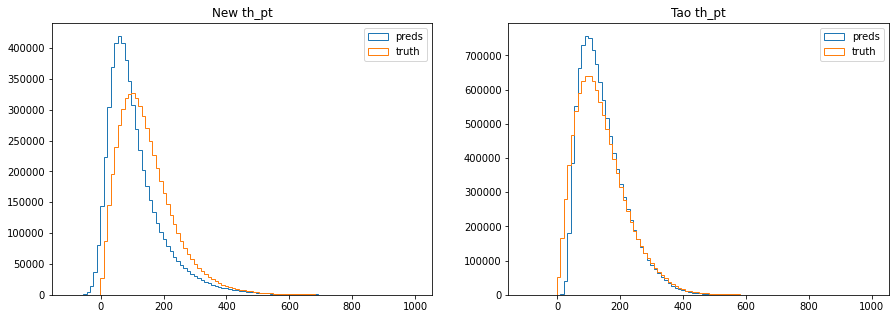

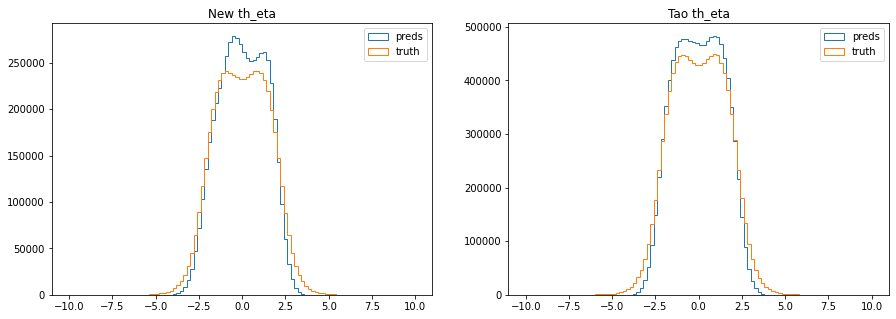

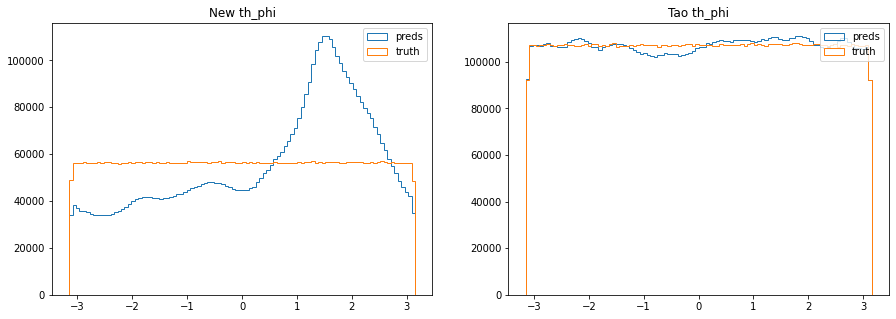

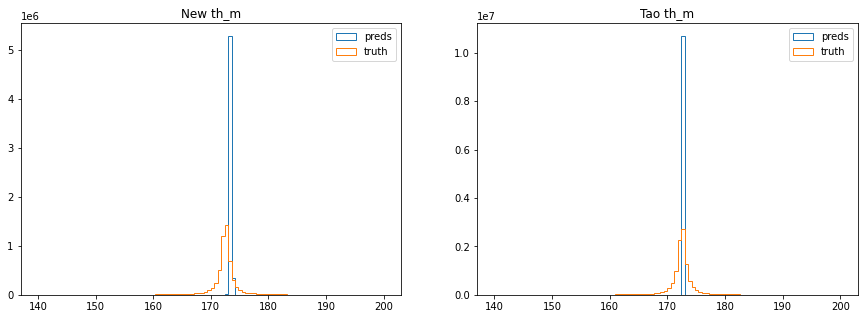

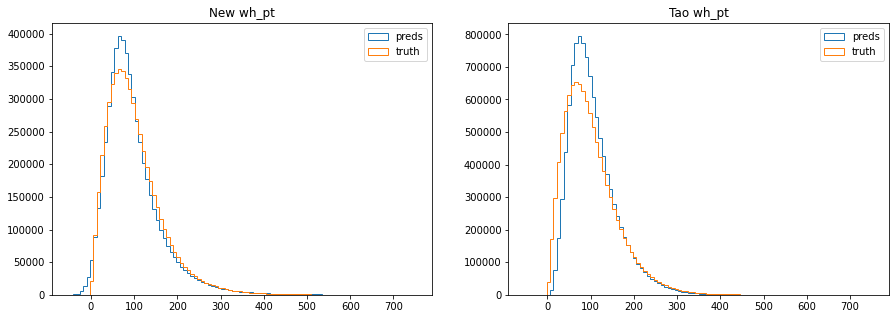

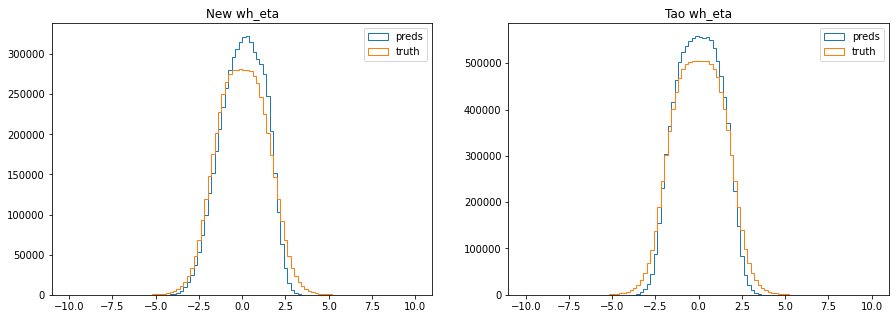

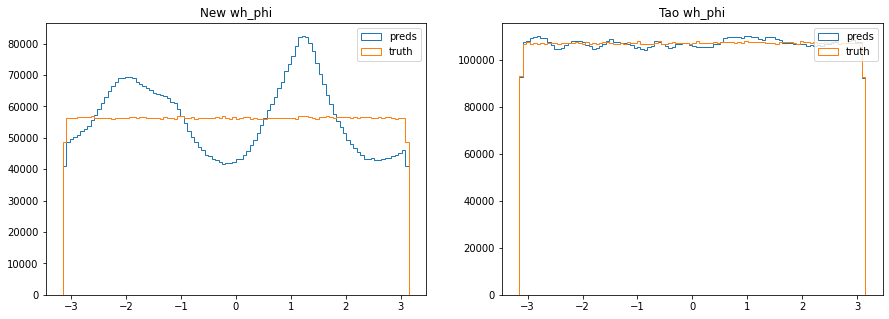

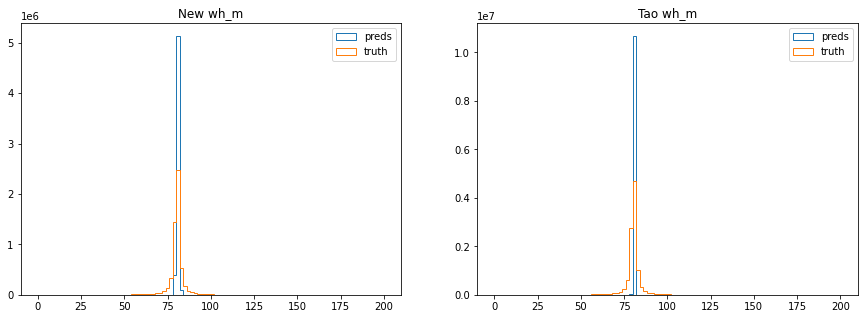

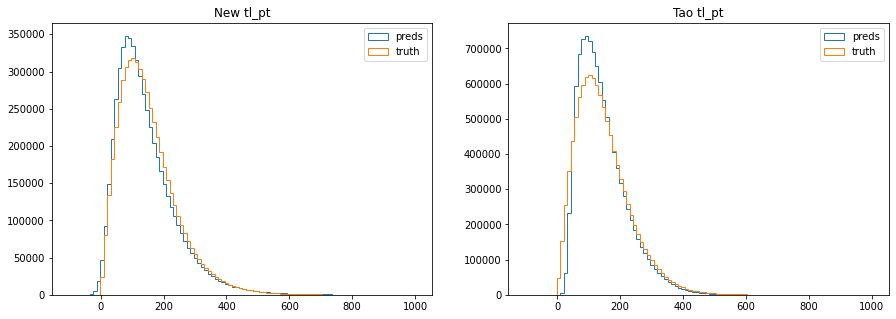

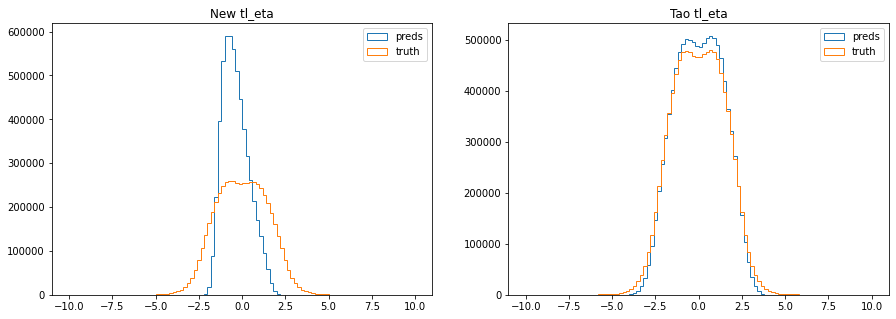

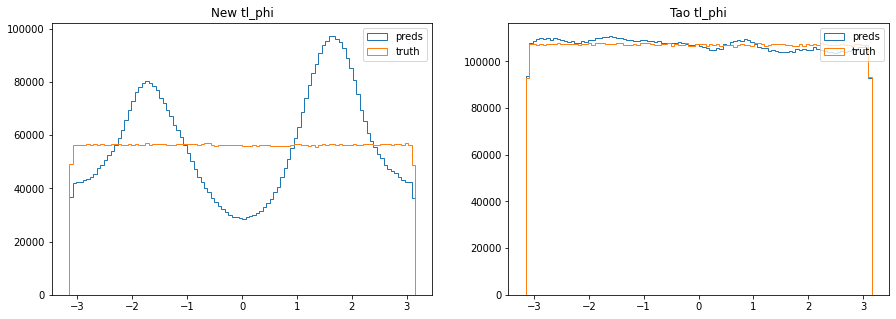

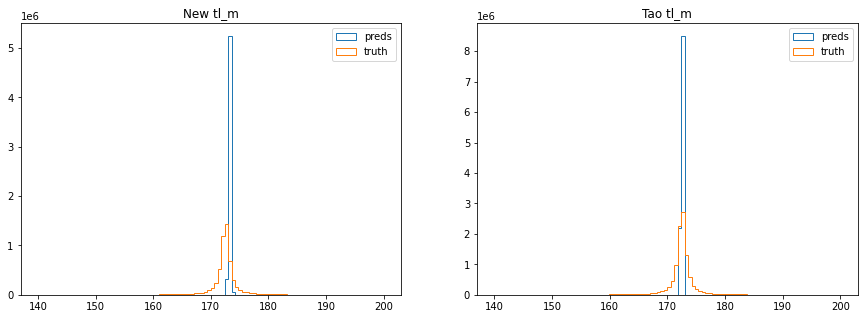

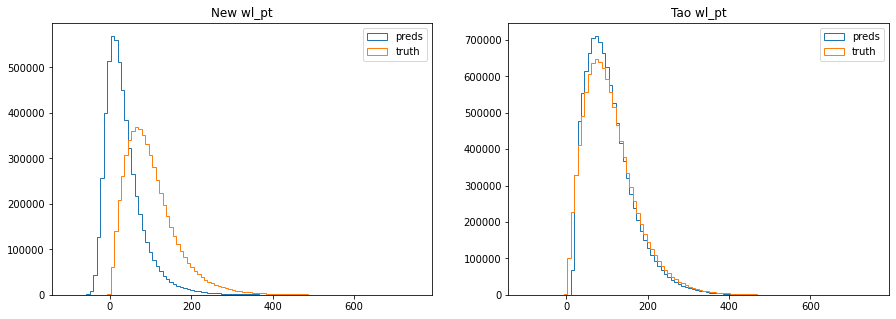

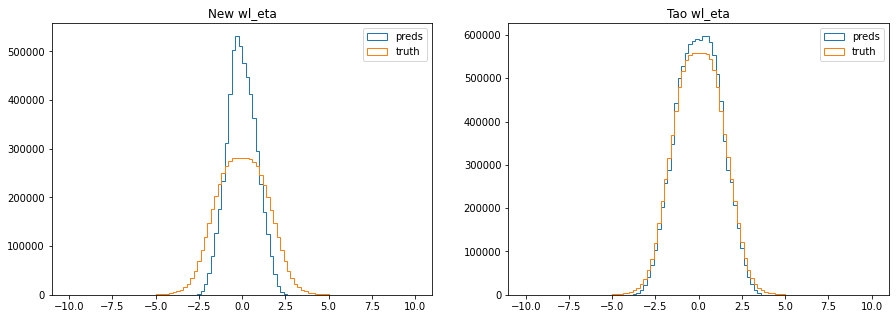

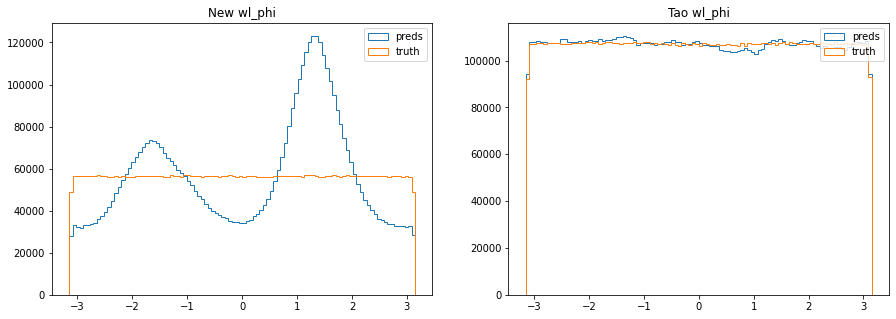

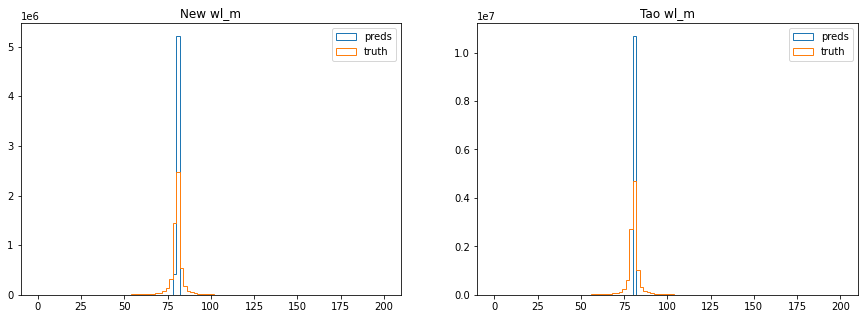

In [7]:
# Load the truth and predictions we just did
preds = np.load(pred_name)
truth = np.load(true_name)

# Load the truth and predictions from Tao's data (for comparison)
preds_tao = np.load('/data/jchishol/Tao_Data/preds_tao.npy')
truth_tao = np.load('/data/jchishol/Tao_Data/true_tao.npy')

# Need to set ranges to ensure everything is on the same scaling/bin sizes
ranges = {'th_pt': (-100,1000), 'th_eta':(-10,10),'th_phi':(-3.15,3.15), 'th_m': (140,200),'wh_pt': (-50,750), 'wh_eta':(-10,10),'wh_phi':(-3.15,3.15), 'wh_m': (0,200), 'tl_pt': (-100,1000), 'tl_eta':(-10,10),'tl_phi':(-3.15,3.15), 'tl_m': (140,200), 'wl_pt': (-100,750), 'wl_eta':(-10,10),'wl_phi':(-3.15,3.15), 'wl_m': (0,200)}

for i in range(len(truth.T)):
    
    # Create subplots
    fig, ax = plt.subplots(1,2, figsize = (15, 5))
    
    # Plot new data
    ax[0].set_title('New '+Y_keys[i])
    ax[0].hist(preds[:,i],bins=100,range=ranges[Y_keys[i]],histtype='step')
    ax[0].hist(truth[:,i],bins=100,range=ranges[Y_keys[i]],histtype='step')
    ax[0].legend(['preds','truth'])
        
    # Plot Tao's data
    ax[1].set_title('Tao '+Y_keys[i])
    ax[1].hist(preds_tao[:,i],bins=100,range=ranges[Y_keys[i]],histtype='step')
    ax[1].hist(truth_tao[:,i],bins=100,range=ranges[Y_keys[i]],histtype='step')
    ax[1].legend(['preds','truth'])

## Plot Inputs

<ipython-input-8-1decf091b9cb>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(var)


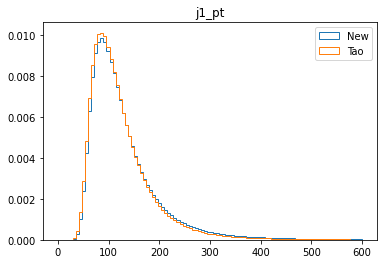

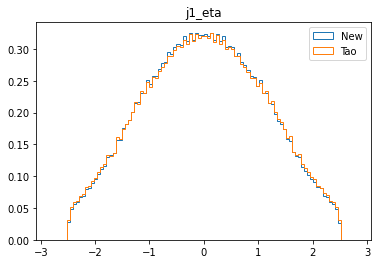

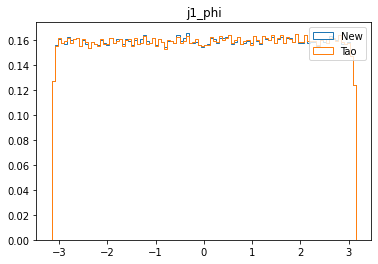

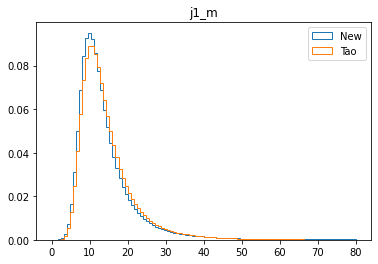

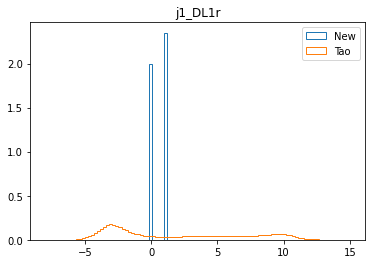

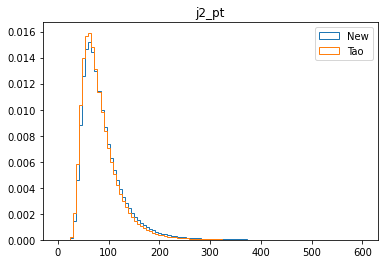

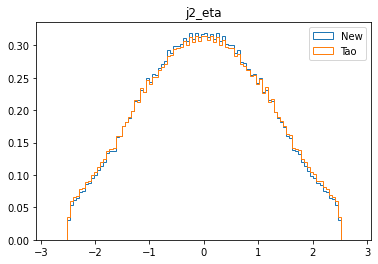

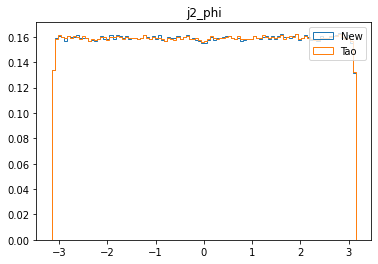

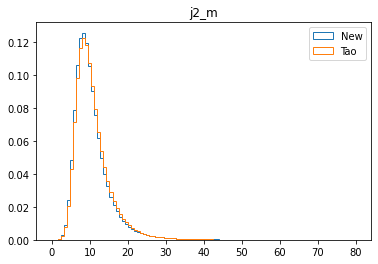

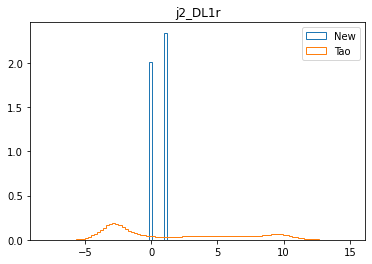

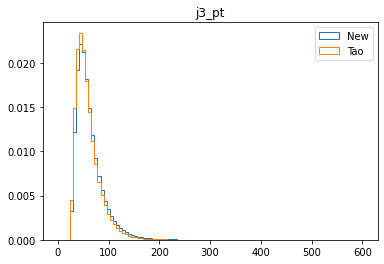

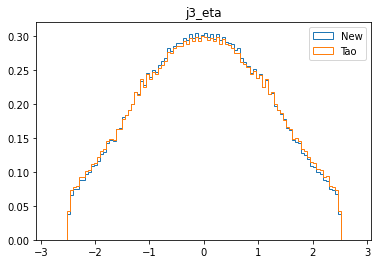

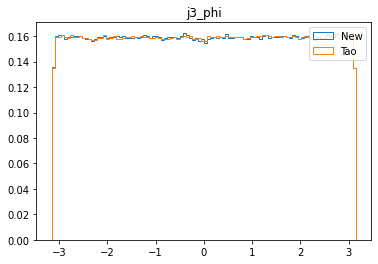

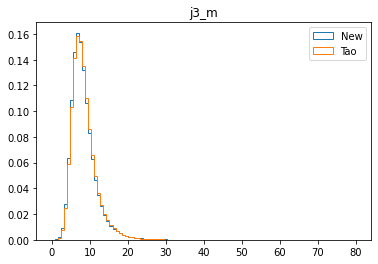

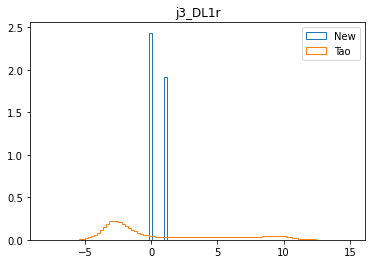

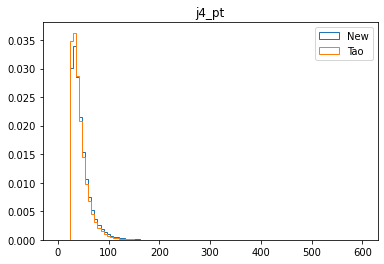

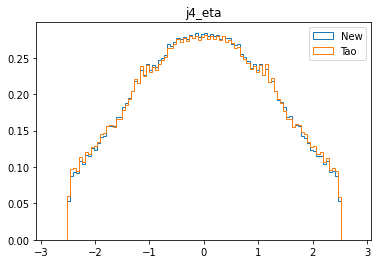

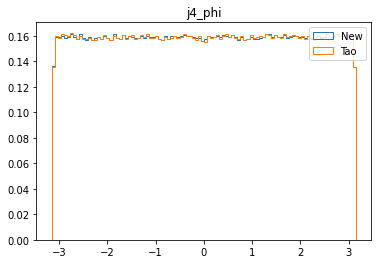

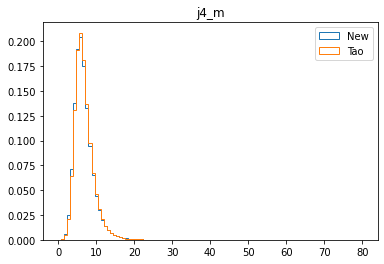

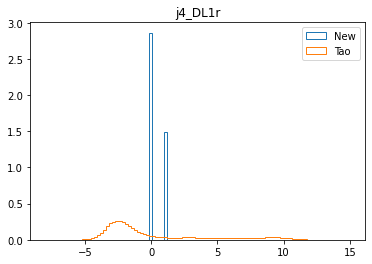

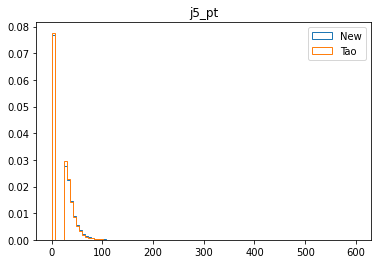

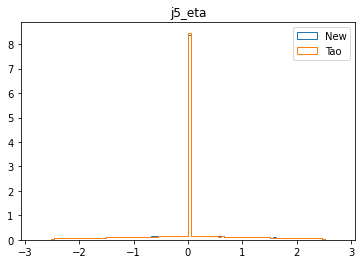

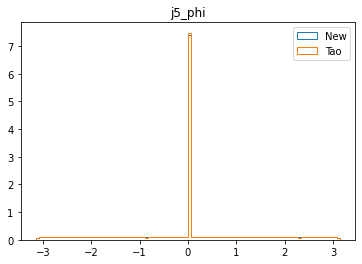

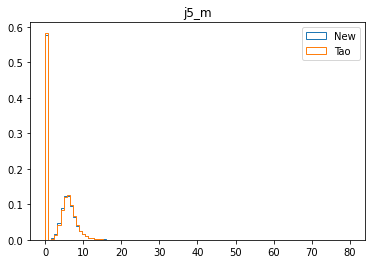

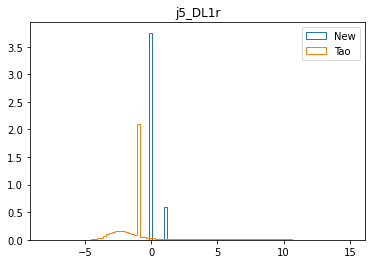

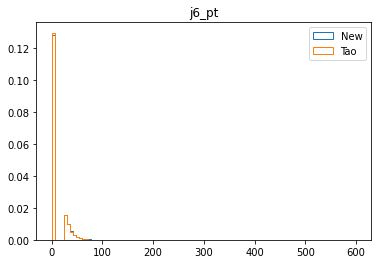

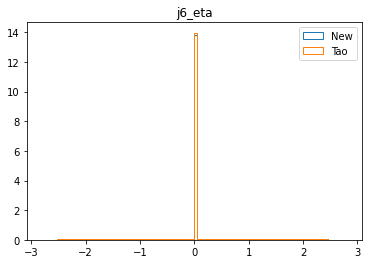

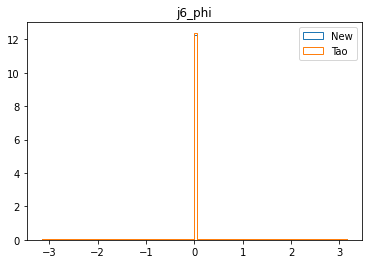

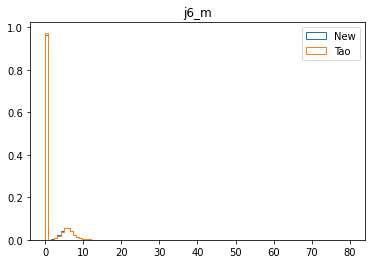

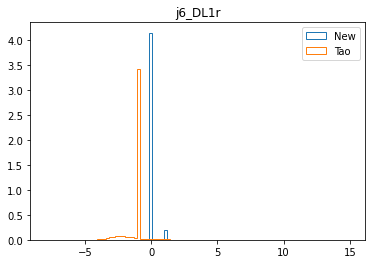

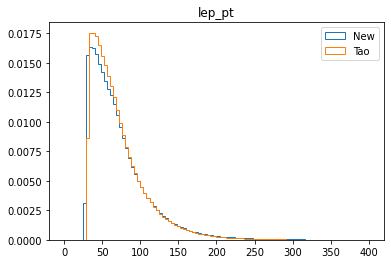

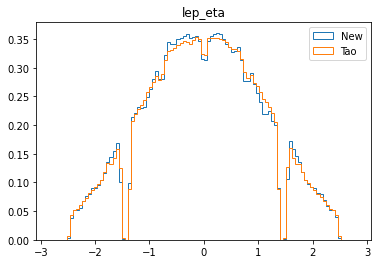

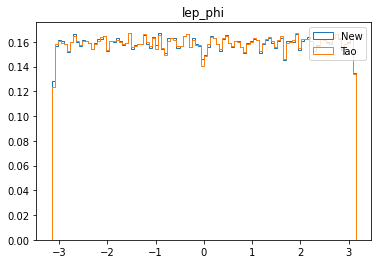

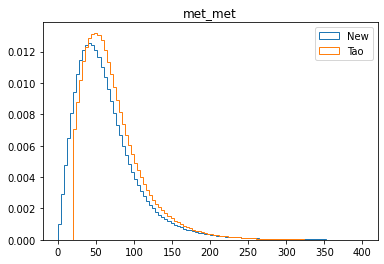

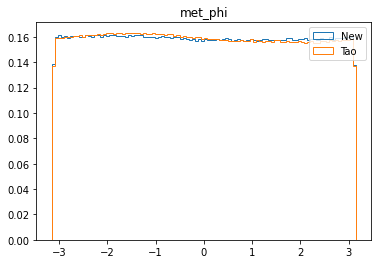

In [8]:
dataset_tao = h5py.File('/data/jchishol/Tao_Data/variables_tt_re_padded.h5','r')

ranges = {'j1_pt':(0,600),'j1_eta':(-2.8,2.8),'j1_phi':(-3.15,3.15),'j1_m':(0,80),'j1_DL1r':(-8,15),
         'j2_pt':(0,600),'j2_eta':(-2.8,2.8),'j2_phi':(-3.15,3.15),'j2_m':(0,80),'j2_DL1r':(-8,15),
         'j3_pt':(0,600),'j3_eta':(-2.8,2.8),'j3_phi':(-3.15,3.15),'j3_m':(0,80),'j3_DL1r':(-8,15),
         'j4_pt':(0,600),'j4_eta':(-2.8,2.8),'j4_phi':(-3.15,3.15),'j4_m':(0,80),'j4_DL1r':(-8,15),
         'j5_pt':(0,600),'j5_eta':(-2.8,2.8),'j5_phi':(-3.15,3.15),'j5_m':(0,80),'j5_DL1r':(-8,15),
         'j6_pt':(0,600),'j6_eta':(-2.8,2.8),'j6_phi':(-3.15,3.15),'j6_m':(0,80),'j6_DL1r':(-8,15),
         'lep_pt':(0,400), 'lep_eta':(-2.8,2.8),'lep_phi':(-3.15,3.15),'met_met':(0,400),'met_phi':(-3.15,3.15)}

for var in X_keys:
    plt.figure(var)
    plt.title(var)
    plt.hist(np.array(dataset.get(var)),bins=100,range=ranges[var],density=True,histtype='step')
    plt.hist(np.array(dataset_tao.get(var)),bins=100,range=ranges[var],density=True,histtype='step')
    plt.legend(['New','Tao'])

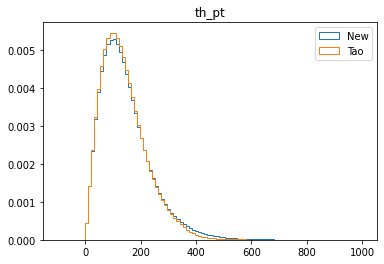

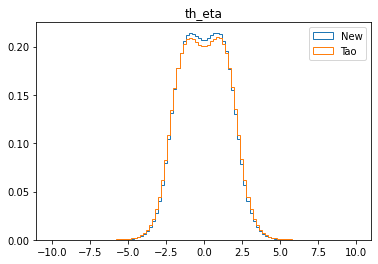

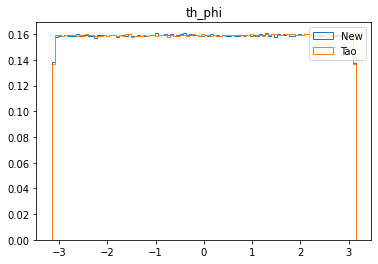

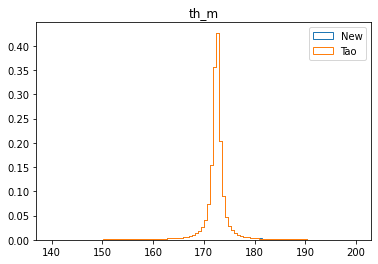

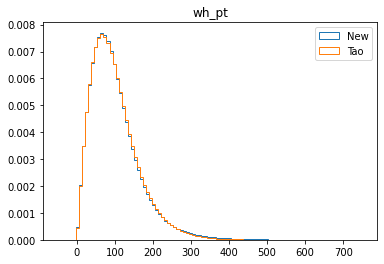

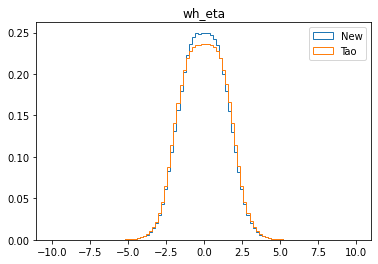

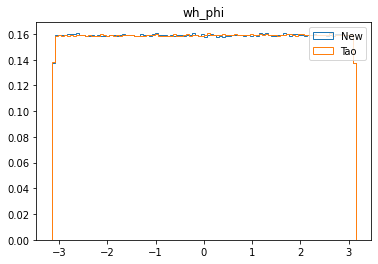

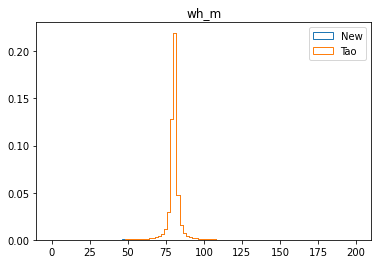

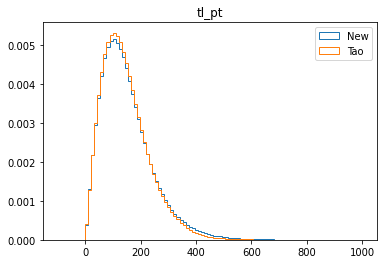

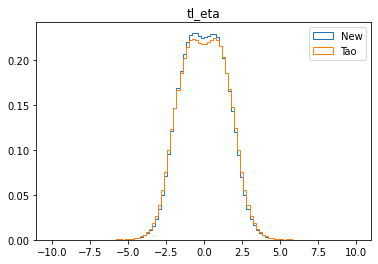

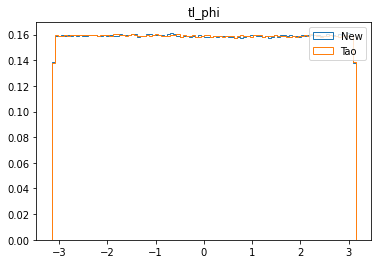

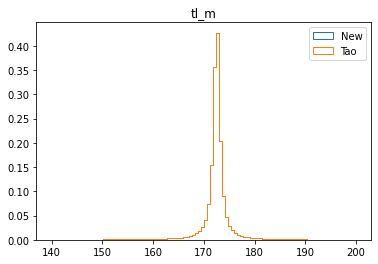

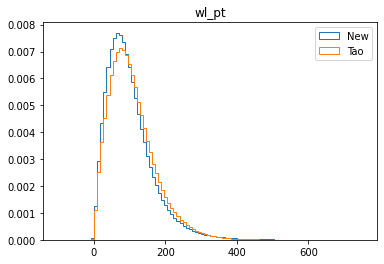

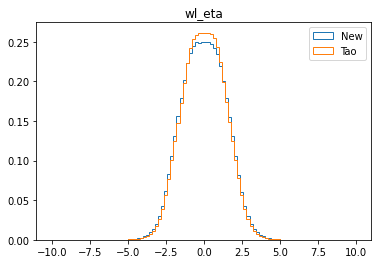

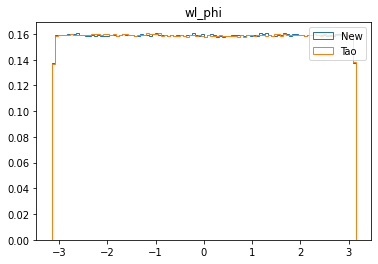

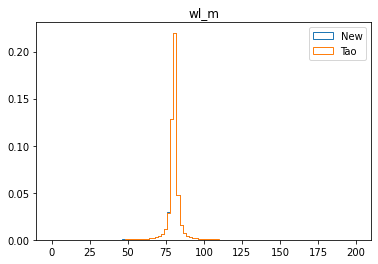

In [9]:
ranges = {'th_pt': (-100,1000), 'th_eta':(-10,10),'th_phi':(-3.15,3.15), 'th_m': (140,200),'wh_pt': (-50,750), 'wh_eta':(-10,10),'wh_phi':(-3.15,3.15), 'wh_m': (0,200), 'tl_pt': (-100,1000), 'tl_eta':(-10,10),'tl_phi':(-3.15,3.15), 'tl_m': (140,200), 'wl_pt': (-100,750), 'wl_eta':(-10,10),'wl_phi':(-3.15,3.15), 'wl_m': (0,200)}

for var in Y_keys:
    plt.figure(var)
    plt.title(var)
    plt.hist(np.array(dataset.get(var)),bins=100,range=ranges[var],density=True,histtype='step')
    plt.hist(np.array(dataset_tao.get(var)),bins=100,range=ranges[var],density=True,histtype='step') 
    plt.legend(['New','Tao'])

## Plot Scaled Inputs

<ipython-input-13-895279ec971e>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(X_names[i])


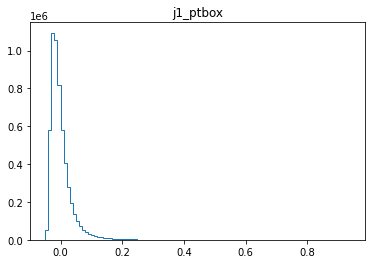

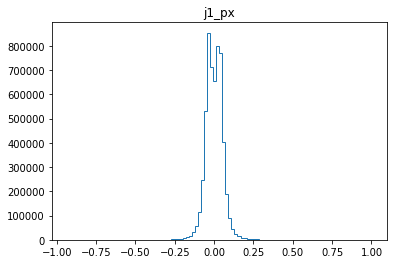

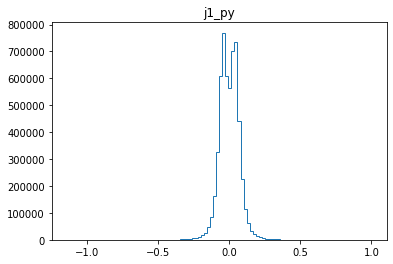

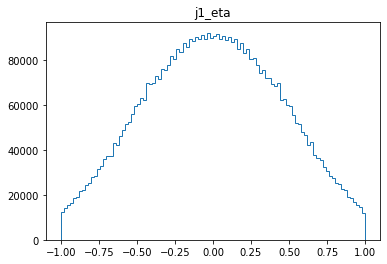

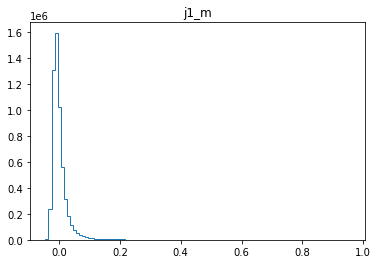

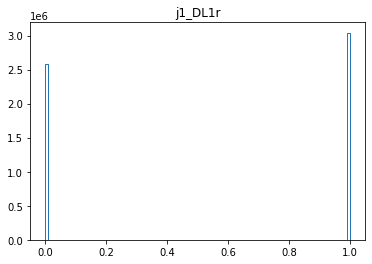

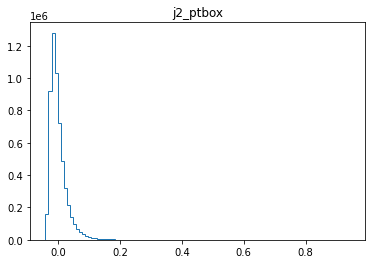

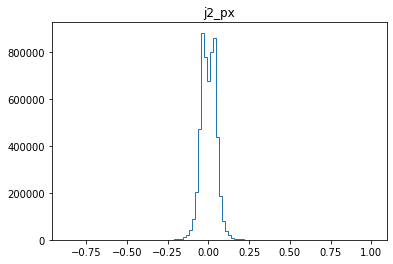

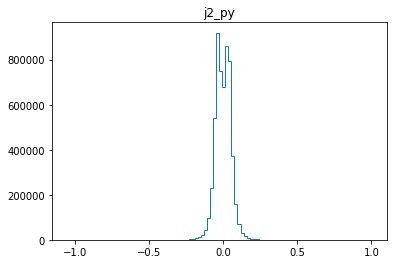

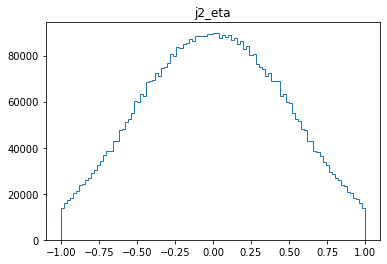

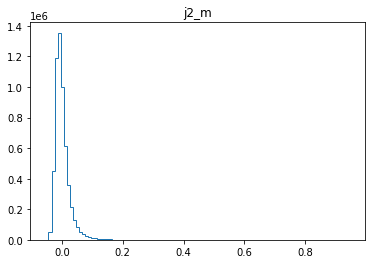

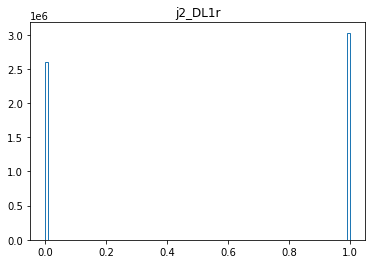

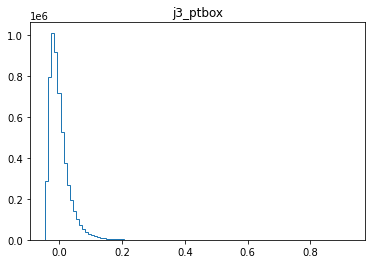

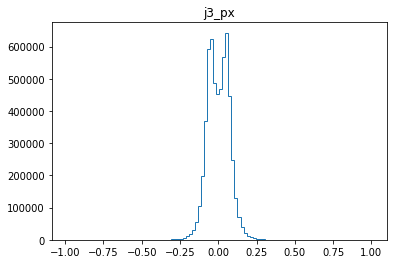

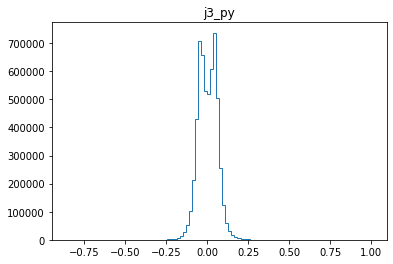

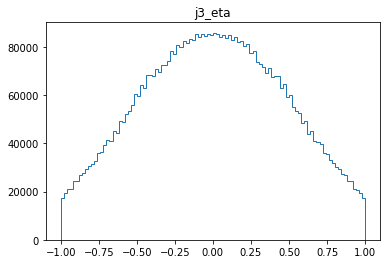

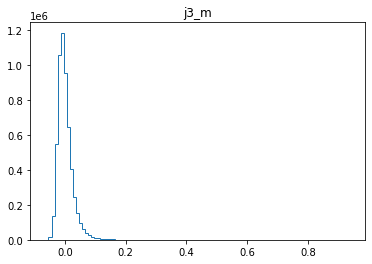

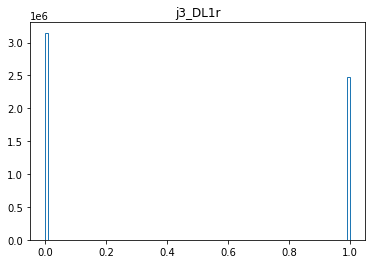

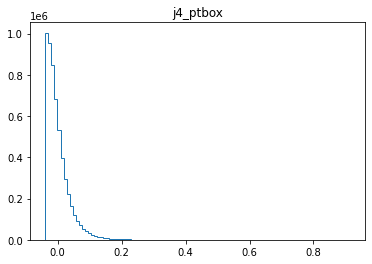

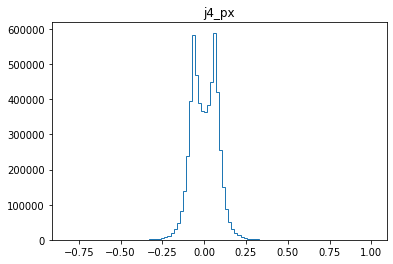

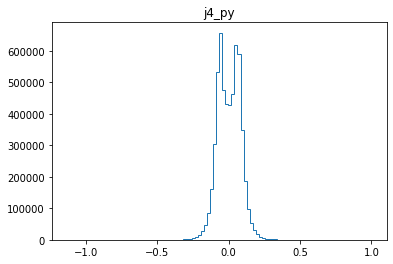

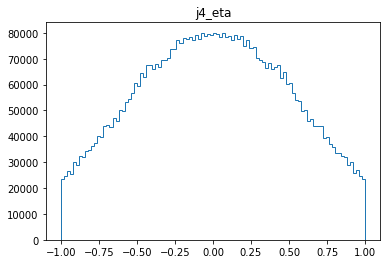

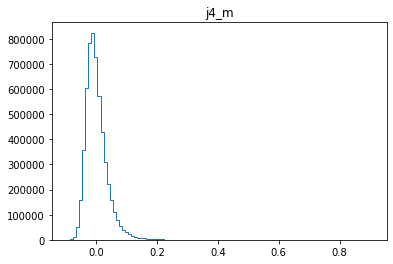

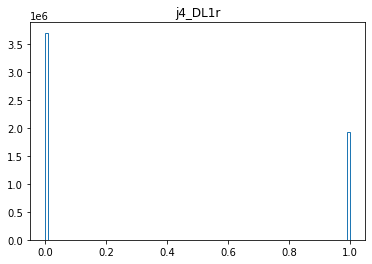

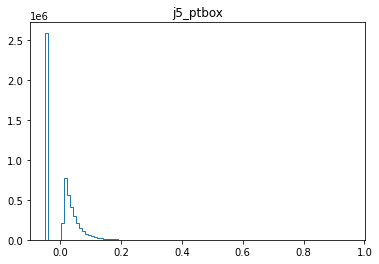

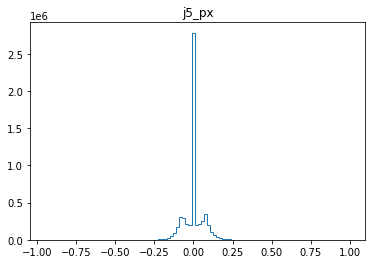

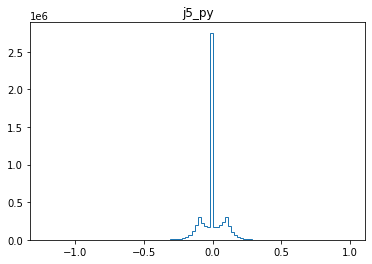

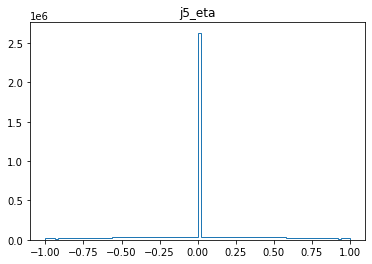

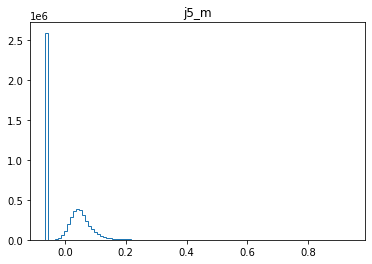

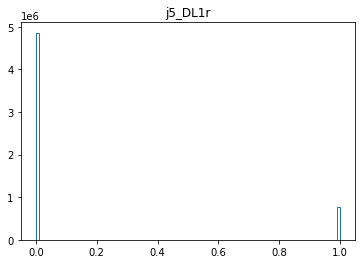

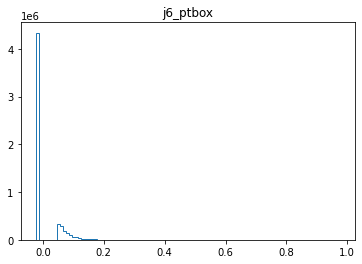

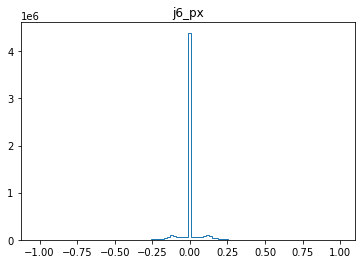

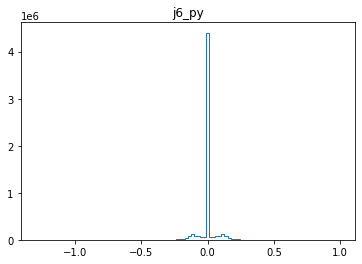

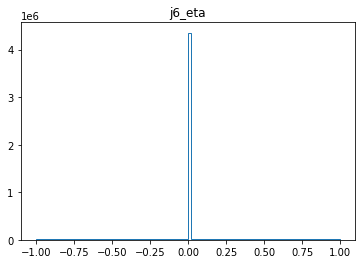

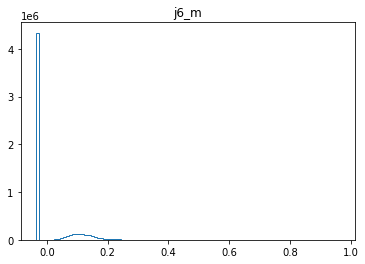

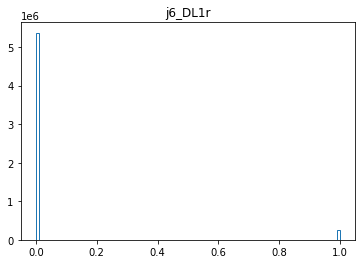

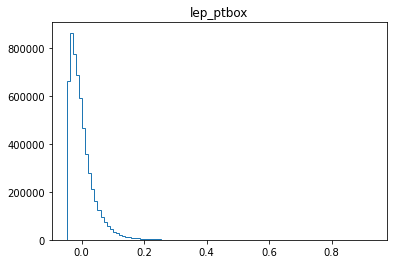

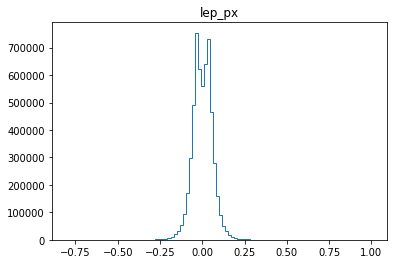

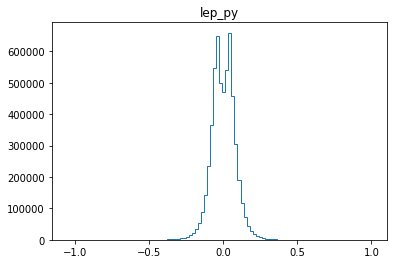

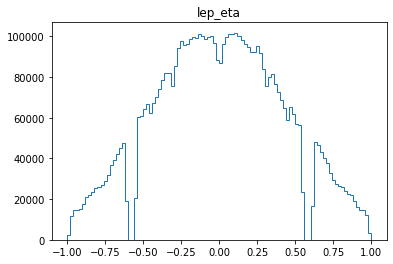

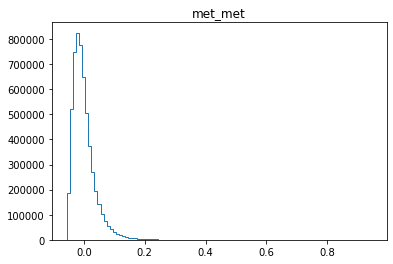

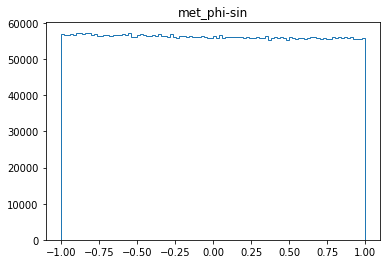

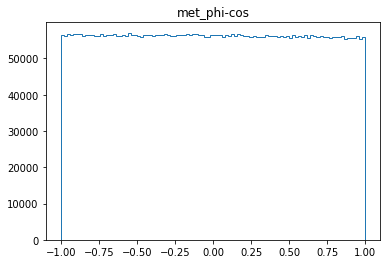

In [13]:
for i in range(len(X_total[0])):
    plt.figure(X_names[i])
    plt.title(X_names[i])
    plt.hist(X_total[:,i],bins=100,histtype='step')

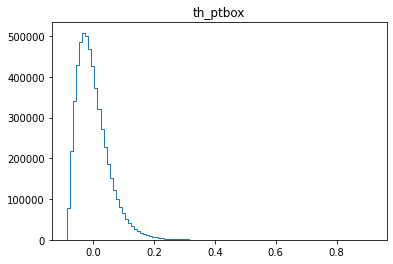

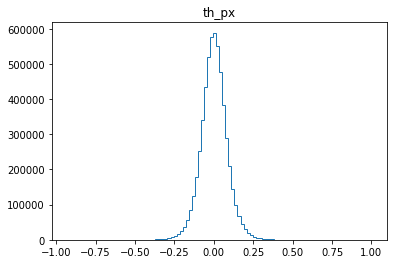

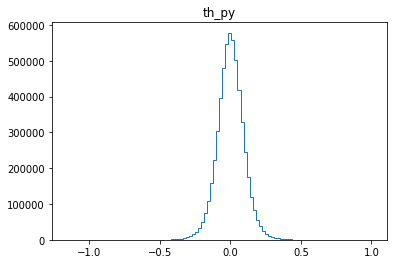

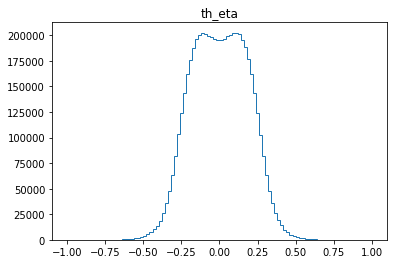

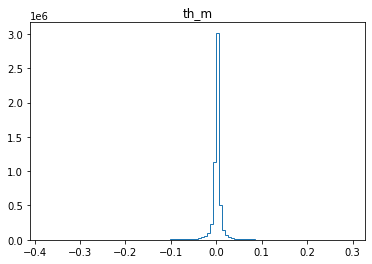

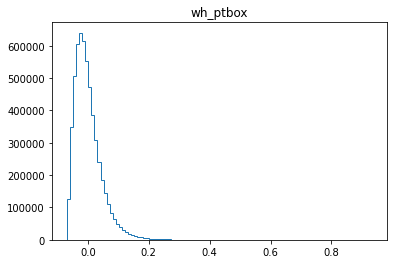

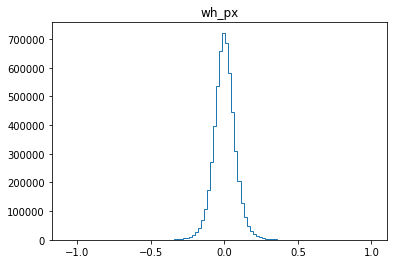

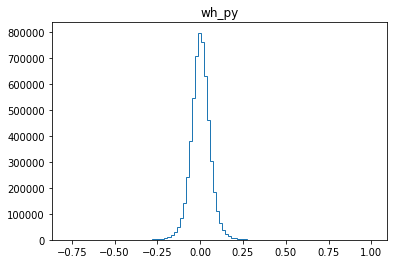

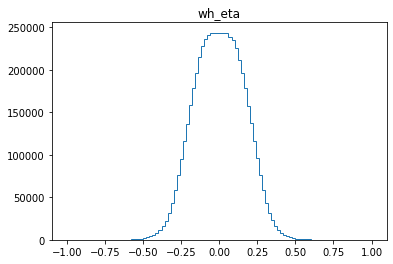

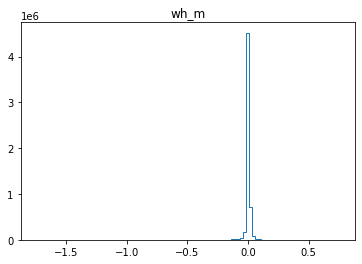

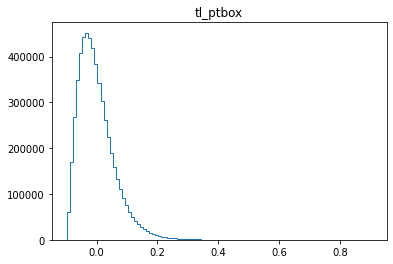

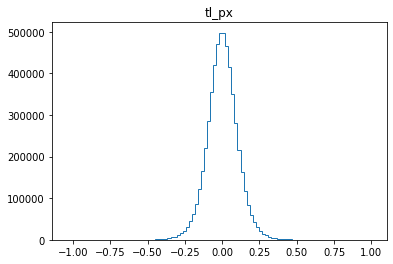

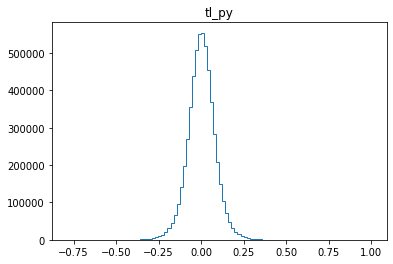

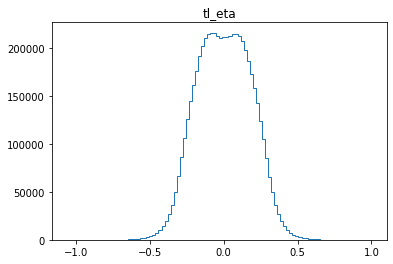

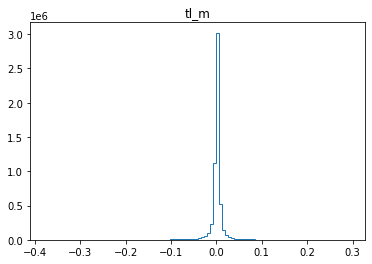

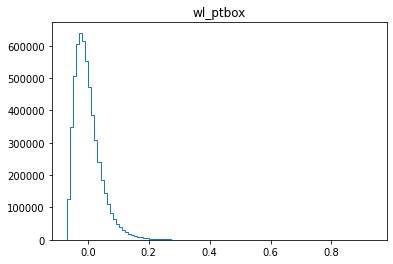

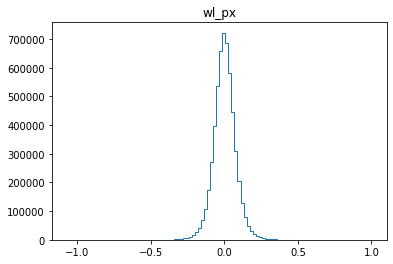

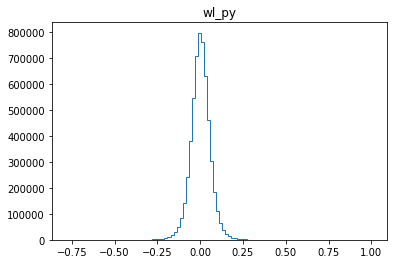

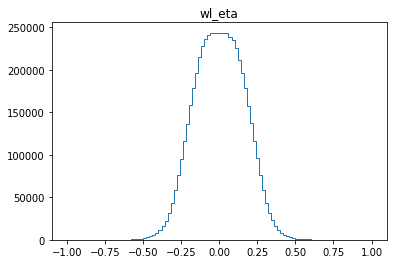

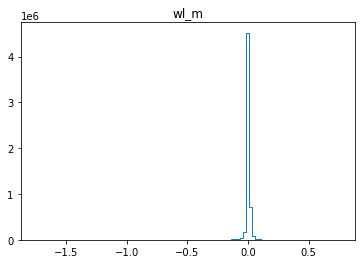

In [12]:
for i in range(len(Y_total[0])):  
    if i==3 or i==8 or i==18:   # th_eta, wh_eta, and wl_eta have extreme outliers
        plt.figure(Y_names[i])
        plt.title(Y_names[i])
        plt.hist(Y_total[:,i],bins=100,range=(-1,1),histtype='step')
    else:
        plt.figure(Y_names[i])
        plt.title(Y_names[i])
        plt.hist(Y_total[:,i],bins=100,histtype='step')